# Updraft-downdraft coupling

Thomas Schanzer  
January 2022

In this notebook we explore approaches to coupling downdrafts to updrafts in our scheme.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import pandas as pd
from scipy.interpolate import interp1d
import sys

import metpy.calc as mpcalc
from metpy.units import units

sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator

## Generating a typical updraft

We use the Singapore sounding and generate an updraft that starts near the surface with a temperature perturbation of 0.6 K and an entrainment rate of 0.25/km. We choose a critical liquid water content of 2 g/kg, which is typical of cumulonimbus clouds.

In [64]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
generator = ThermalGenerator(pressure, height, temperature, specific_humidity)

In [85]:
%%time
i_init = pressure.size - 1
t_pert = 0.6*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.25/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km
l_crit = 2e-3*units.dimensionless

updraft = generator.updraft(
    i_init, t_pert, q_pert, l_initial, w_initial, rate, dnu_db, drag, l_crit)

CPU times: user 1.43 s, sys: 6.4 ms, total: 1.44 s
Wall time: 1.46 s


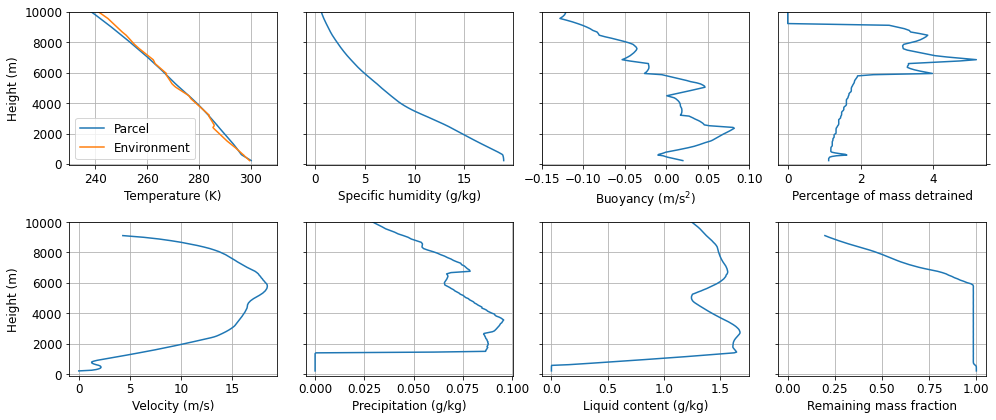

In [86]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))

axes[0,0].plot(updraft.temperature, height, label='Parcel')
axes[0,0].plot(temperature, height, label='Environment')
axes[0,0].legend()
axes[0,0].set(xlabel='Temperature (K)', ylabel='Height (m)')
axes[0,0].set_xlim(230, 310)

axes[0,1].plot(updraft.specific_humidity*1e3, height)
axes[0,1].set(xlabel='Specific humidity (g/kg)', ylabel='')

axes[0,2].plot(updraft.buoyancy, height)
axes[0,2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')
axes[0,2].set_xlim(-0.15, 0.1)

axes[0,3].plot(updraft.m_detrained*1e2, height)
axes[0,3].set(xlabel='Percentage of mass detrained', ylabel='')
axes[0,3].yaxis.tick_right()

axes[1,0].plot(updraft.velocity, height)
axes[1,0].set(xlabel='Velocity (m/s)', ylabel='Height (m)')

axes[1,1].plot(updraft.precipitation*1e3, height)
axes[1,1].set(xlabel='Precipitation (g/kg)', ylabel='')

axes[1,2].plot(updraft.liquid_content*1e3, height)
axes[1,2].set(xlabel='Liquid content (g/kg)', ylabel='')

axes[1,3].plot(updraft.m_remaining, height)
axes[1,3].set(xlabel='Remaining mass fraction', ylabel='')
axes[1,3].set_xlim(-0.05, 1.05)

for ax in axes.ravel():
    ax.grid()
    ax.set_ylim(-100, 10000)

for ax in axes[:,1:].ravel():
    ax.set_yticklabels([])

fig.tight_layout()

## Idea 1

We first try a downdraft that starts at the level of maximum precipitation. The amount of liquid evaporated into it is the total amount precipitated by the updraft at and above the initiation level.

In [112]:
%%time
max_precip_level = np.nanargmax(updraft.precipitation*updraft.m_remaining)
total_precip = np.nansum((updraft.precipitation*updraft.m_remaining)[:max_precip_level+1])
downdraft = generator.downdraft(
    max_precip_level, total_precip, w_initial, rate, dnu_db, drag)

CPU times: user 414 ms, sys: 3.88 ms, total: 418 ms
Wall time: 418 ms


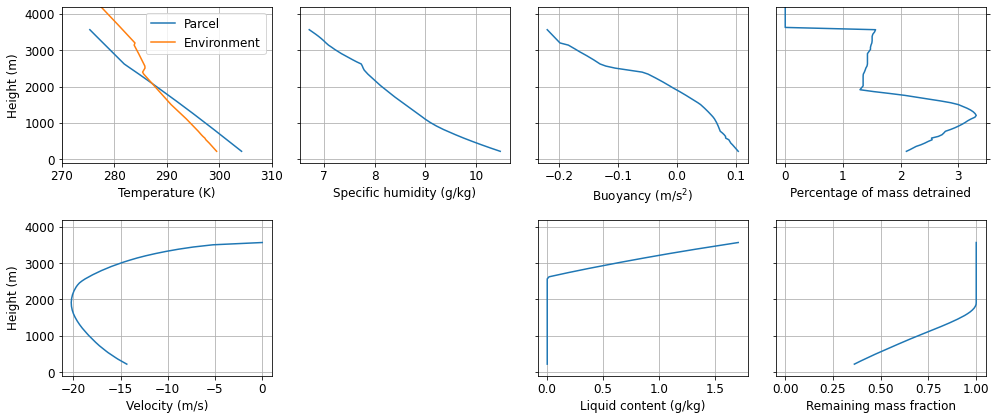

In [113]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))

axes[0,0].plot(downdraft.temperature, height, label='Parcel')
axes[0,0].plot(temperature, height, label='Environment')
axes[0,0].legend()
axes[0,0].set(xlabel='Temperature (K)', ylabel='Height (m)')
axes[0,0].set_xlim(270, 310)

axes[0,1].plot(downdraft.specific_humidity*1e3, height)
axes[0,1].set(xlabel='Specific humidity (g/kg)', ylabel='')

axes[0,2].plot(downdraft.buoyancy, height)
axes[0,2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')

axes[0,3].plot(downdraft.m_detrained*1e2, height)
axes[0,3].set(xlabel='Percentage of mass detrained', ylabel='')
axes[0,3].yaxis.tick_right()

axes[1,0].plot(downdraft.velocity, height)
axes[1,0].set(xlabel='Velocity (m/s)', ylabel='Height (m)')

axes[1,2].plot(downdraft.liquid_content*1e3, height)
axes[1,2].set(xlabel='Liquid content (g/kg)', ylabel='')

axes[1,3].plot(downdraft.m_remaining, height)
axes[1,3].set(xlabel='Remaining mass fraction', ylabel='')
axes[1,3].set_xlim(-0.05, 1.05)

for ax in axes.ravel():
    ax.grid()
    ax.set_ylim(-100, 4200)

for ax in axes[:,1:].ravel():
    ax.set_yticklabels([])

axes[1,1].remove()
fig.tight_layout()

## Idea 2

It may be unreasonable to assume that the liquid precipitated out of the updraft at all levels is able to reach the downdraft initiation level at the same time, without evaporating into the environment on the way. We may try only evaporating into the downdraft parcel the precipitation from a 1 km layer above the initiation level.

In [146]:
%%time
max_precip_level = np.nanargmax(updraft.precipitation*updraft.m_remaining)
max_precip_height = height[max_precip_level]
precip_start_level = (
    height.size - 1
    - np.searchsorted(height[::-1], max_precip_height + 1*units.km)
)
total_precip = np.nansum((
    updraft.precipitation*updraft.m_remaining
)[precip_start_level:max_precip_level+1])
downdraft = generator.downdraft(
    max_precip_level, total_precip, w_initial, rate, dnu_db, drag)

CPU times: user 179 ms, sys: 2.64 ms, total: 182 ms
Wall time: 181 ms


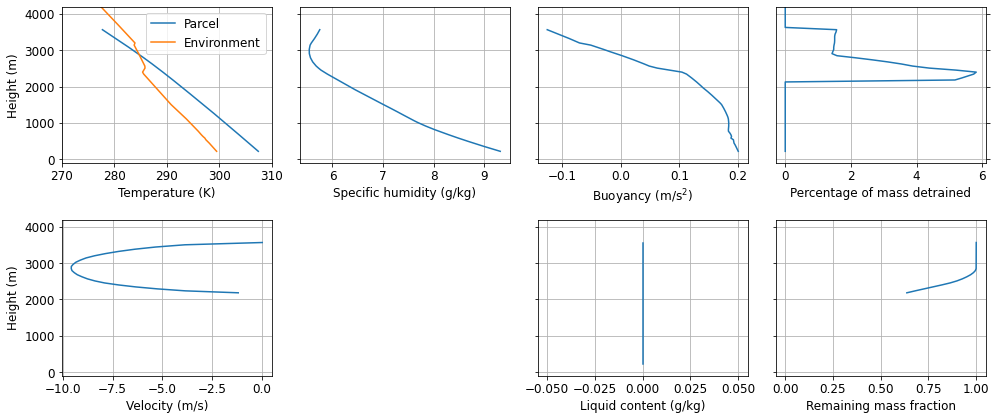

In [147]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))

axes[0,0].plot(downdraft.temperature, height, label='Parcel')
axes[0,0].plot(temperature, height, label='Environment')
axes[0,0].legend()
axes[0,0].set(xlabel='Temperature (K)', ylabel='Height (m)')
axes[0,0].set_xlim(270, 310)

axes[0,1].plot(downdraft.specific_humidity*1e3, height)
axes[0,1].set(xlabel='Specific humidity (g/kg)', ylabel='')

axes[0,2].plot(downdraft.buoyancy, height)
axes[0,2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')

axes[0,3].plot(downdraft.m_detrained*1e2, height)
axes[0,3].set(xlabel='Percentage of mass detrained', ylabel='')
axes[0,3].yaxis.tick_right()

axes[1,0].plot(downdraft.velocity, height)
axes[1,0].set(xlabel='Velocity (m/s)', ylabel='Height (m)')

axes[1,2].plot(downdraft.liquid_content*1e3, height)
axes[1,2].set(xlabel='Liquid content (g/kg)', ylabel='')

axes[1,3].plot(downdraft.m_remaining, height)
axes[1,3].set(xlabel='Remaining mass fraction', ylabel='')
axes[1,3].set_xlim(-0.05, 1.05)

for ax in axes.ravel():
    ax.grid()
    ax.set_ylim(-100, 4200)

for ax in axes[:,1:].ravel():
    ax.set_yticklabels([])

axes[1,1].remove()
fig.tight_layout()

In [164]:
%%time
max_precip_level = np.nanargmax(updraft.precipitation*updraft.m_remaining)
max_precip_height = height[max_precip_level]
precip_start_levels = range(max_precip_level - 1, -1, -1)
precip_start_heights = height[precip_start_levels]
downdrafts = np.empty(len(precip_start_levels), dtype='object')
for n, i in enumerate(precip_start_levels):
    sys.stdout.write(f'\rCalculation {n+1} of {downdrafts.size}   ')
    total_precip = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[precip_start_levels[i]:max_precip_level+1])
    downdrafts[i] = generator.downdraft(
        max_precip_level, total_precip, w_initial, rate, dnu_db, drag)
sys.stdout.write('\n')

min_heights = np.zeros(downdrafts.size)*units.meter
max_velocities = np.zeros(downdrafts.size)*units.meter/units.second
for i in range(downdrafts.size):
    min_heights[i] = np.nanmin(
        np.where(np.isnan(downdrafts[i].velocity), np.nan, height)
    )
    max_velocities[i] = np.nanmin(downdrafts[i].velocity)

Calculation 132 of 132   
CPU times: user 43.7 s, sys: 170 ms, total: 43.8 s
Wall time: 43.9 s


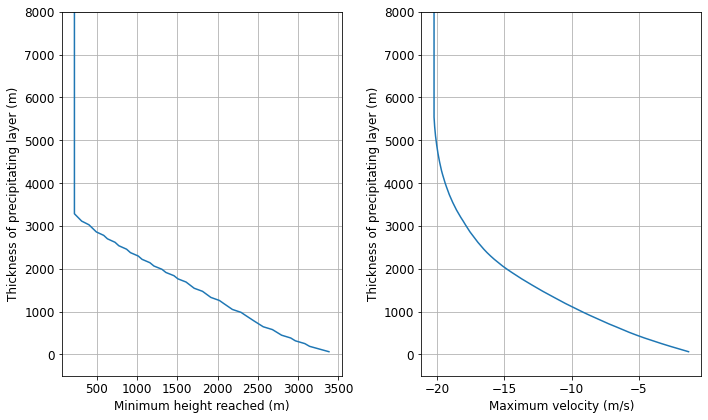

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].plot(min_heights, precip_start_heights - max_precip_height)
axes[0].set(xlabel='Minimum height reached (m)',
            ylabel='Thickness of precipitating layer (m)')
axes[0].set_ylim(-500, 8000)
axes[0].grid()
axes[1].plot(max_velocities, precip_start_heights - max_precip_height)
axes[1].set(xlabel='Maximum velocity (m/s)',
            ylabel='Thickness of precipitating layer (m)')
axes[1].set_ylim(-500, 8000)
axes[1].grid()
fig.tight_layout()

## Idea 3

The work of Torri and Kuang (2016) using a Lagrangian particle dispersion model found that precipitation-driven downdrafts are initiated at very low levels; 98% of the particles had initial heights below 2.5 km. We now try initiating our downdraft from the level of maximum precipitation in the lowest 2.5 km.

In [178]:
%%time
max_precip_level = np.nanargmax(np.where(
    height > 2.5*units.km, 0, updraft.precipitation*updraft.m_remaining
))
max_precip_height = height[max_precip_level]
precip_start_level = (
    height.size - 1
    - np.searchsorted(height[::-1], max_precip_height + 1*units.km)
)
total_precip = np.nansum((
    updraft.precipitation*updraft.m_remaining
)[precip_start_level:max_precip_level+1])
downdraft = generator.downdraft(
    max_precip_level, total_precip, w_initial, rate, dnu_db, drag)

CPU times: user 248 ms, sys: 3.84 ms, total: 252 ms
Wall time: 251 ms


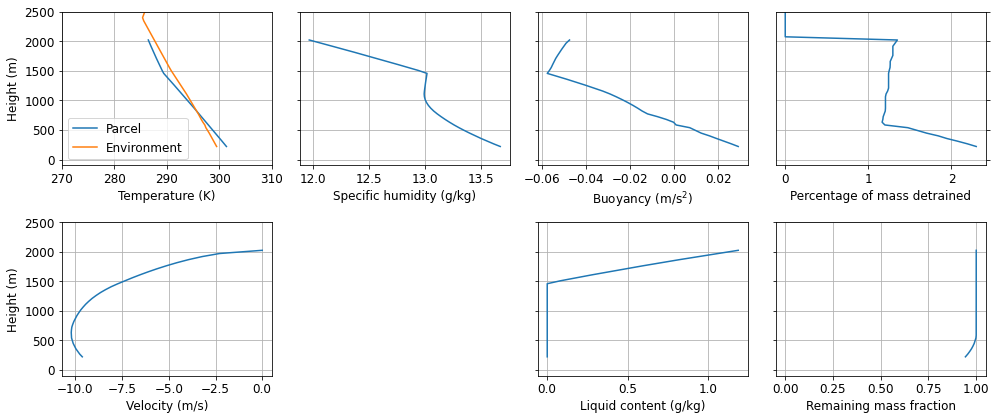

In [179]:
fig, axes = plt.subplots(2, 4, figsize=(14,6))

axes[0,0].plot(downdraft.temperature, height, label='Parcel')
axes[0,0].plot(temperature, height, label='Environment')
axes[0,0].legend()
axes[0,0].set(xlabel='Temperature (K)', ylabel='Height (m)')
axes[0,0].set_xlim(270, 310)

axes[0,1].plot(downdraft.specific_humidity*1e3, height)
axes[0,1].set(xlabel='Specific humidity (g/kg)', ylabel='')

axes[0,2].plot(downdraft.buoyancy, height)
axes[0,2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')

axes[0,3].plot(downdraft.m_detrained*1e2, height)
axes[0,3].set(xlabel='Percentage of mass detrained', ylabel='')
axes[0,3].yaxis.tick_right()

axes[1,0].plot(downdraft.velocity, height)
axes[1,0].set(xlabel='Velocity (m/s)', ylabel='Height (m)')

axes[1,2].plot(downdraft.liquid_content*1e3, height)
axes[1,2].set(xlabel='Liquid content (g/kg)', ylabel='')

axes[1,3].plot(downdraft.m_remaining, height)
axes[1,3].set(xlabel='Remaining mass fraction', ylabel='')
axes[1,3].set_xlim(-0.05, 1.05)

for ax in axes.ravel():
    ax.grid()
    ax.set_ylim(-100, 2500)

for ax in axes[:,1:].ravel():
    ax.set_yticklabels([])

axes[1,1].remove()
fig.tight_layout()

In [173]:
%%time
max_precip_level = np.nanargmax(np.where(
    height > 2.5*units.km, 0, updraft.precipitation*updraft.m_remaining
))
max_precip_height = height[max_precip_level]
precip_start_levels = range(max_precip_level - 1, -1, -1)
precip_start_heights = height[precip_start_levels]
downdrafts = np.empty(len(precip_start_levels), dtype='object')
for n, i in enumerate(precip_start_levels):
    sys.stdout.write(f'\rCalculation {n+1} of {downdrafts.size}   ')
    total_precip = np.nansum((
        updraft.precipitation*updraft.m_remaining
    )[precip_start_levels[i]:max_precip_level+1])
    downdrafts[i] = generator.downdraft(
        max_precip_level, total_precip, w_initial, rate, dnu_db, drag)
sys.stdout.write('\n')

min_heights = np.zeros(downdrafts.size)*units.meter
max_velocities = np.zeros(downdrafts.size)*units.meter/units.second
for i in range(downdrafts.size):
    min_heights[i] = np.nanmin(
        np.where(np.isnan(downdrafts[i].velocity), np.nan, height)
    )
    max_velocities[i] = np.nanmin(downdrafts[i].velocity)

Calculation 159 of 159   
CPU times: user 55.9 s, sys: 198 ms, total: 56.1 s
Wall time: 56.1 s


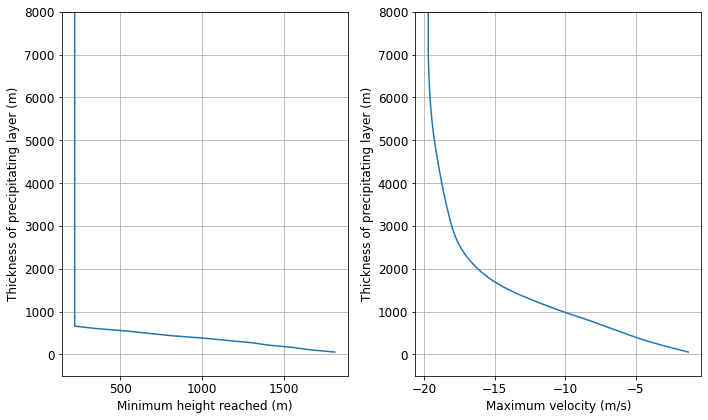

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].plot(min_heights, precip_start_heights - max_precip_height)
axes[0].set(xlabel='Minimum height reached (m)',
            ylabel='Thickness of precipitating layer (m)')
axes[0].set_ylim(-500, 8000)
axes[0].grid()
axes[1].plot(max_velocities, precip_start_heights - max_precip_height)
axes[1].set(xlabel='Maximum velocity (m/s)',
            ylabel='Thickness of precipitating layer (m)')
axes[1].set_ylim(-500, 8000)
axes[1].grid()
fig.tight_layout()